In [1]:
# Importing necessities for the analysis
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix,precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import joblib
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier,BalancedBaggingClassifier
from sklearn.calibration import CalibratedClassifierCV


In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("max_colwidth", None)

In [3]:
# Loading the data
df_churn=pd.read_csv('data/Churn_prepared.csv',index_col='customerID')

In [4]:

rf_model = joblib.load('random_forest_model.pkl')
logreg_model = joblib.load('logistic_regression_model.pkl')
svm_model = joblib.load('svc_model.pkl')
xgb_model = joblib.load('xgb_model.pkl')
mlp_model = joblib.load('mlp_model.pkl')
gnb_model = joblib.load('naive_bayes_model.pkl')
bb_model = joblib.load('balanced_bagging_model.pkl')
ee_model= joblib.load('easy_ensemble_model.pkl')
models=[rf_model,logreg_model,svm_model,xgb_model,mlp_model,gnb_model]
model_names = ['Random Forest','easy_ensemble_model', 'Logistic Regression', 'SVC', 'XGBoost', 'MLP', 'Naive Bayes','balanced_bagging_model']


In [5]:
# Define new models: BalancedRandomForestClassifier and EasyEnsembleClassifier
brf_model = BalancedRandomForestClassifier()

# Define CalibratedClassifierCV for the RandomForest model (both Isotonic and Sigmoid)
calibrated_rf_isotonic = CalibratedClassifierCV(estimator=rf_model, method='isotonic', cv=5)
calibrated_rf_sigmoid = CalibratedClassifierCV(estimator=rf_model, method='sigmoid', cv=5)

# Initialize BalancedBaggingClassifier with XGBoost as estimator
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')  # XGBoost model

# Target and features
X = df_churn.drop(columns=['Churn'])
y = df_churn['Churn']

# Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Scale features for models that require scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# List of models and model names
models = [
    rf_model, logreg_model, svm_model, xgb_model, mlp_model, gnb_model,
    brf_model, ee_model, calibrated_rf_isotonic, calibrated_rf_sigmoid,ee_model,
    bb_model  # Add BalancedBaggingClassifier here
]

model_names = [
    'Random Forest', 'Logistic Regression', 'SVC', 'XGBoost', 'MLP', 'Naive Bayes', 
    'Balanced Random Forest', 'Easy Ensemble', 'balanced_bagging_model','easy_ensemble_model',
    'Calibrated RF (Isotonic)', 'Calibrated RF (Sigmoid)', 'Balanced Bagging (XGBoost)'
]

# DataFrame for evaluation metrics
results = pd.DataFrame(columns=['Model', 'Mean Accuracy', 'Mean Precision', 'Mean Recall', 'Mean F1 Score', 'Mean ROC AUC', 'Best Threshold'])

# Evaluate each model 
for model, name in zip(models, model_names):
    if name in ['Logistic Regression', 'SVC', 'MLP']: 
        X_data = X_train_scaled

    else:  
        X_data = X_train

    # Cross-validate model
    cv_accuracy = cross_val_score(model, X_data, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    cv_precision = cross_val_score(model, X_data, y_train, cv=5, scoring='precision', n_jobs=-1)
    cv_recall = cross_val_score(model, X_data, y_train, cv=5, scoring='recall', n_jobs=-1)
    cv_f1 = cross_val_score(model, X_data, y_train, cv=5, scoring='f1', n_jobs=-1)
    cv_roc_auc = cross_val_score(model, X_data, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

    # Fit the model on the full training data to get probabilities
    model.fit(X_data, y_train)
    y_probs = model.predict_proba(X_data)[:, 1] if hasattr(model, 'predict_proba') else None

    # Determine best threshold using precision-recall curve (if applicable)
    if y_probs is not None:
        precision, recall, thresholds = precision_recall_curve(y_train, y_probs)
        f1_scores = 2 * (precision * recall) / (precision + recall)
        best_threshold = thresholds[np.argmax(f1_scores)] if len(thresholds) > 0 else None
    else:
        best_threshold = None

    # Store mean metrics and the best threshold
    new_result = pd.DataFrame({
        'Model': [name],
        'Mean Accuracy': [cv_accuracy.mean()],
        'Mean Precision': [cv_precision.mean()],
        'Mean Recall': [cv_recall.mean()],
        'Mean F1 Score': [cv_f1.mean()],
        'Mean ROC AUC': [cv_roc_auc.mean()],
        'Best Threshold': [best_threshold]
    })

    results = pd.concat([results, new_result], ignore_index=True)

# Display results DataFrame
print(results)

C:\Users\Admin\AppData\Local\Temp\ipykernel_12760\765611243.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_result], ignore_index=True)
c:\Users\Admin\Desktop\Portfolio\churn-analysis\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:17:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Admin\Desktop\Portfolio\churn-analysis\venv\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will fo

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Admin\Desktop\Portfolio\churn-analysis\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Admin\Desktop\Portfolio\churn-analysis\venv\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\Admin\Desktop\Portfolio\churn-analysis\venv\Lib\site-packages\imblearn\base.py", line 42, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\Admin\Desktop\Portfolio\churn-analysis\venv\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'n_estimators' parameter of EasyEnsembleClassifier must be an int in the range [1, inf). Got {'n_estimators': 12, 'estimator': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8266311138487283, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01791817293518791,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=340, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...), 'sampling_strategy': 'auto', 'replacement': False} instead.


In [56]:
results = results.sort_values(by='F1 Score', ascending=False)
results

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,Best Threshold
7,Easy Ensemble,0.740241,0.492255,0.801120,0.609808,0.831143,0.504355
6,Balanced Random Forest,0.746629,0.500000,0.775910,0.608123,0.819416,0.510000
5,Naive Bayes,0.736693,0.487410,0.759104,0.593647,0.819792,0.844222
10,Balanced Bagging (XGBoost),0.706884,0.454545,0.784314,0.575540,0.802050,0.633333
1,Logistic Regression,0.799858,0.623762,0.529412,0.572727,0.828763,0.254403
2,SVC,0.791341,0.601942,0.521008,0.558559,0.823523,0.322067
3,XGBoost,0.787793,0.591772,0.523810,0.555721,0.810116,0.296910
4,MLP,0.787793,0.592357,0.521008,0.554396,0.823491,0.324902
9,Calibrated RF (Sigmoid),0.799148,0.634058,0.490196,0.552923,0.833071,0.231888
8,Calibrated RF (Isotonic),0.799148,0.636029,0.484594,0.550079,0.832247,0.253011


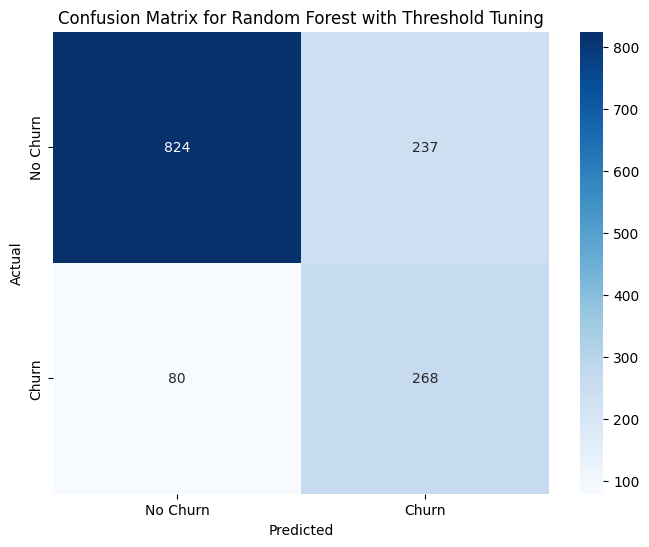

Classification Report for Random Forest with Threshold Tuning:

              precision    recall  f1-score   support

           0       0.91      0.78      0.84      1061
           1       0.53      0.77      0.63       348

    accuracy                           0.78      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.82      0.78      0.79      1409



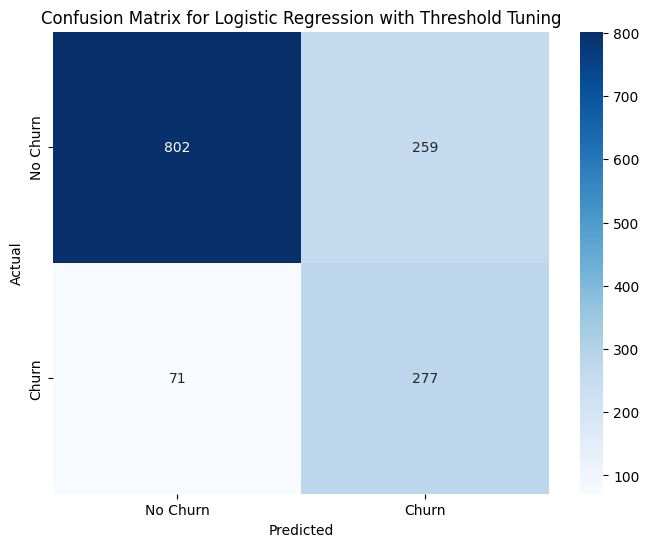

Classification Report for Logistic Regression with Threshold Tuning:

              precision    recall  f1-score   support

           0       0.92      0.76      0.83      1061
           1       0.52      0.80      0.63       348

    accuracy                           0.77      1409
   macro avg       0.72      0.78      0.73      1409
weighted avg       0.82      0.77      0.78      1409



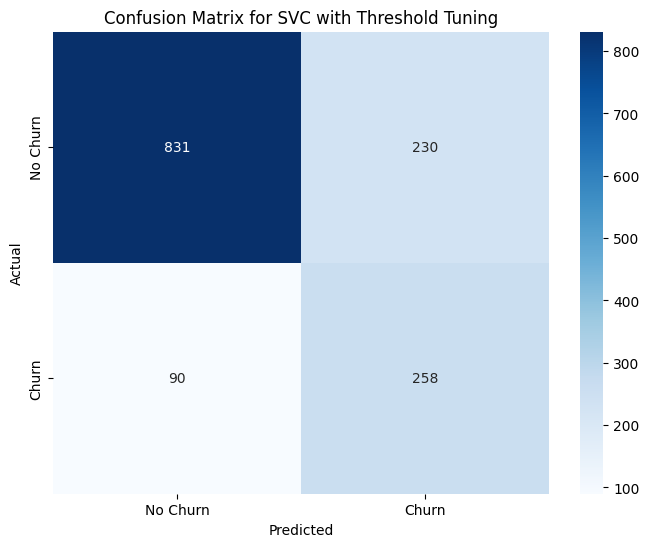

Classification Report for SVC with Threshold Tuning:

              precision    recall  f1-score   support

           0       0.90      0.78      0.84      1061
           1       0.53      0.74      0.62       348

    accuracy                           0.77      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.81      0.77      0.78      1409



c:\Users\Admin\Desktop\Portfolio\churn-analysis\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:41:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


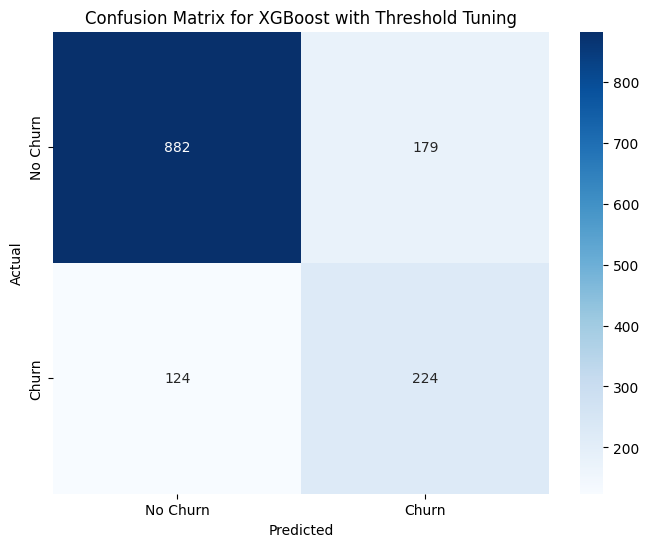

Classification Report for XGBoost with Threshold Tuning:

              precision    recall  f1-score   support

           0       0.88      0.83      0.85      1061
           1       0.56      0.64      0.60       348

    accuracy                           0.78      1409
   macro avg       0.72      0.74      0.72      1409
weighted avg       0.80      0.78      0.79      1409



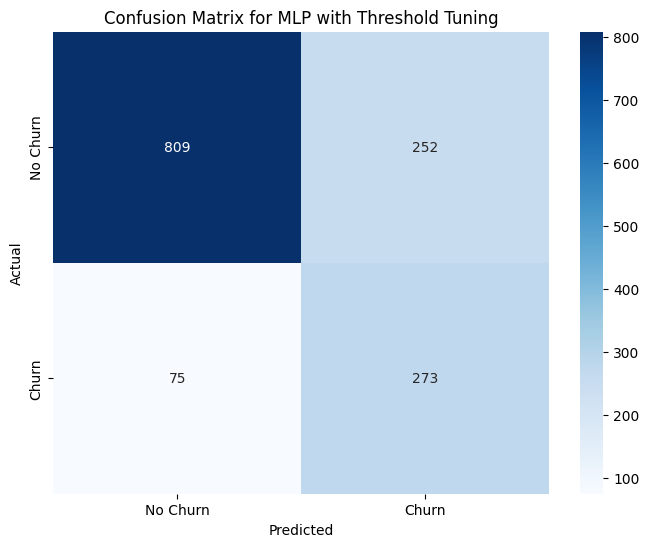

Classification Report for MLP with Threshold Tuning:

              precision    recall  f1-score   support

           0       0.92      0.76      0.83      1061
           1       0.52      0.78      0.63       348

    accuracy                           0.77      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.82      0.77      0.78      1409



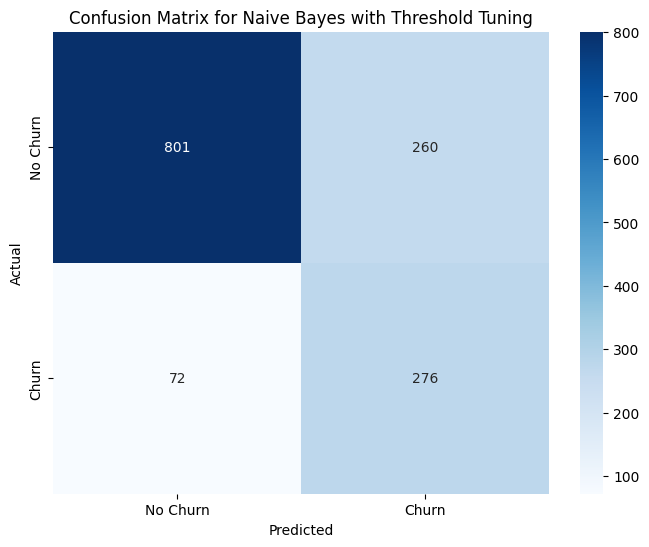

Classification Report for Naive Bayes with Threshold Tuning:

              precision    recall  f1-score   support

           0       0.92      0.75      0.83      1061
           1       0.51      0.79      0.62       348

    accuracy                           0.76      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.82      0.76      0.78      1409



c:\Users\Admin\Desktop\Portfolio\churn-analysis\venv\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\Admin\Desktop\Portfolio\churn-analysis\venv\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\Admin\Desktop\Portfolio\churn-analysis\venv\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `F

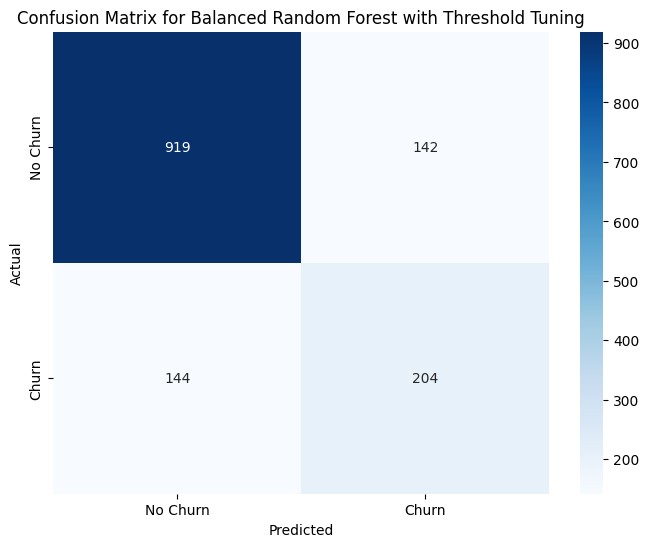

Classification Report for Balanced Random Forest with Threshold Tuning:

              precision    recall  f1-score   support

           0       0.86      0.87      0.87      1061
           1       0.59      0.59      0.59       348

    accuracy                           0.80      1409
   macro avg       0.73      0.73      0.73      1409
weighted avg       0.80      0.80      0.80      1409



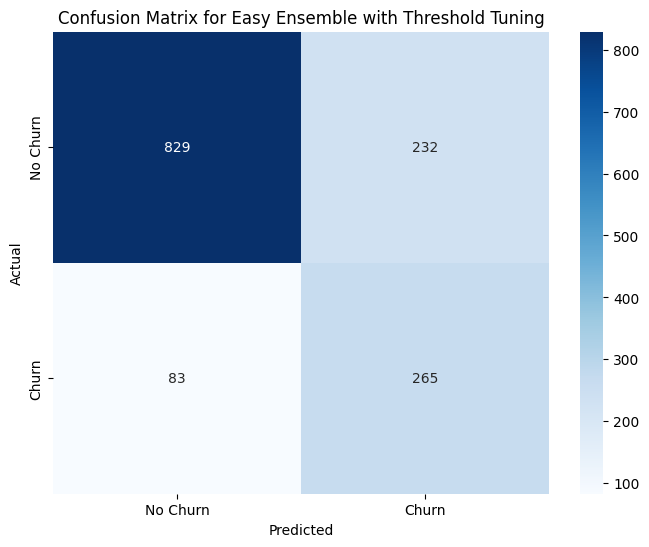

Classification Report for Easy Ensemble with Threshold Tuning:

              precision    recall  f1-score   support

           0       0.91      0.78      0.84      1061
           1       0.53      0.76      0.63       348

    accuracy                           0.78      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.82      0.78      0.79      1409



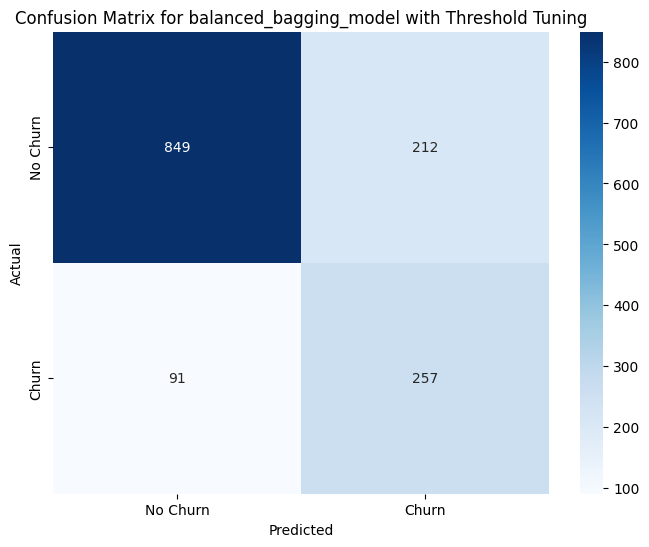

Classification Report for balanced_bagging_model with Threshold Tuning:

              precision    recall  f1-score   support

           0       0.90      0.80      0.85      1061
           1       0.55      0.74      0.63       348

    accuracy                           0.78      1409
   macro avg       0.73      0.77      0.74      1409
weighted avg       0.82      0.78      0.79      1409



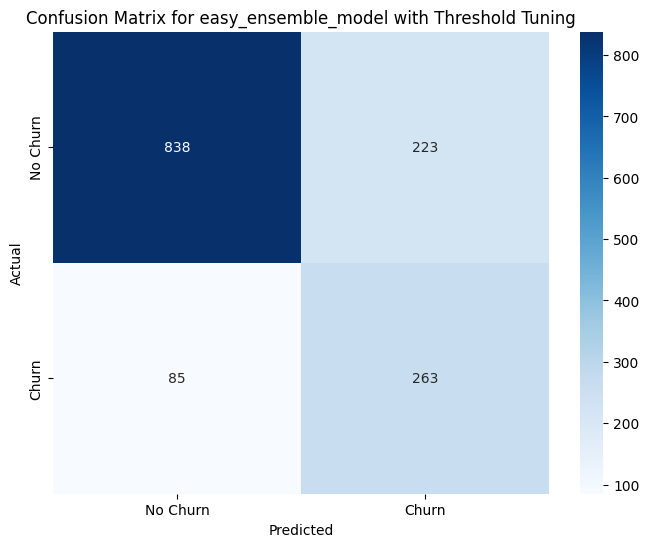

Classification Report for easy_ensemble_model with Threshold Tuning:

              precision    recall  f1-score   support

           0       0.91      0.79      0.84      1061
           1       0.54      0.76      0.63       348

    accuracy                           0.78      1409
   macro avg       0.72      0.77      0.74      1409
weighted avg       0.82      0.78      0.79      1409



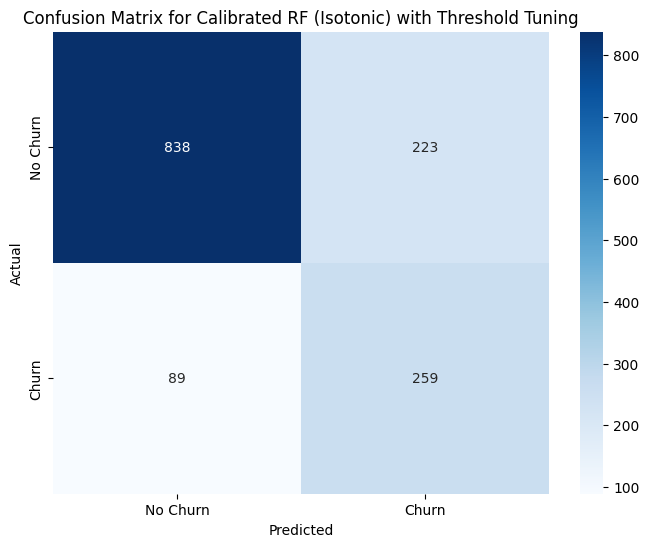

Classification Report for Calibrated RF (Isotonic) with Threshold Tuning:

              precision    recall  f1-score   support

           0       0.90      0.79      0.84      1061
           1       0.54      0.74      0.62       348

    accuracy                           0.78      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.78      0.79      1409



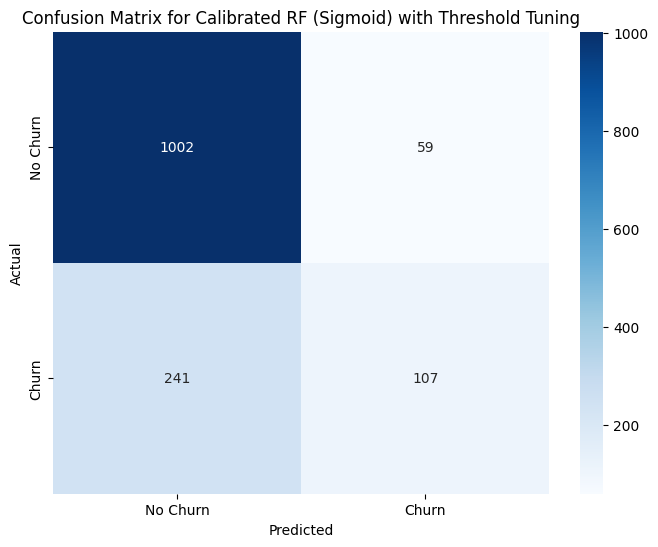

Classification Report for Calibrated RF (Sigmoid) with Threshold Tuning:

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      1061
           1       0.64      0.31      0.42       348

    accuracy                           0.79      1409
   macro avg       0.73      0.63      0.64      1409
weighted avg       0.77      0.79      0.76      1409



In [25]:
# predictions with the best threshold
for model, name in zip(models, model_names):
    if name in ['Logistic Regression', 'SVC', 'MLP']:
        model.fit(X_train_scaled, y_train)
        y_probs = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_probs = model.predict_proba(X_test)[:, 1]

    # Apply the best threshold
    y_pred_adjusted = (y_probs >= results.loc[results['Model'] == name, 'Best Threshold'].values[0]).astype(int)

    # Confusion matrix and classification report
    conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix for {name} with Threshold Tuning')
    plt.show()

    class_report = classification_report(y_test, y_pred_adjusted)
    print(f'Classification Report for {name} with Threshold Tuning:\n')
    print(class_report)
